In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy import inf

In [2]:
gamma = 0.95

# P(s, a, s)
P = np.array([
    [[0.45, 0, 0.55],
    [0, 0, 1]],
    [[0, 0, 1],
    [0.5, 0.4, 0.1]],
    [[0.6, 0, 0.4],
     [0, 0.9, 0.1]
    ]])

# R(s, a)
R = np.array([[-0.4, 0],
     [2, 0],
     [-1, -0.5]
])

def maxi(arr):
    i = np.argmax(arr)
    v = arr[i]
    return v, i

In [3]:
class RL:
    def __init__(self, gamma=0.95, P=P, R=R):
        self.S = P.shape[0]
        self.A = P.shape[1]
        self.epoch = []
        self.values = []
        self.P = P
        self.R = R
        self.vstar = None
        self.gamma = gamma

    def get_qvalue(self, v):
        """
        Returns:
            Q(s,a) for the value v
        """
        val = np.zeros((self.S, self.A))

        for s in range(self.S):
            for a in range(self.A):
                val[s, a] = R[s,a] + self.gamma * P[s, a, :].dot(v)

        return val
    
    def set_vstar(self, v):
        self.vstar = v
        
    def policy_evaluation(self, pi):
        p = np.zeros((self.S,self.S))
        r = np.zeros((self.S,1))

        for s in range(self.S):
            r[s] = R[s, pi[s]]
            p[s, :] = P[s, pi[s], :]

        return np.linalg.inv((np.eye(self.S) - self.gamma * p)).dot(r)[:, 0]

    def clean_plot(self):
        self.epoch = []
        self.values = []
    
    def policy_iteration(self, eps):
        self.clean_plot()
        # initialize arbitrary policy
        v = np.array([0] * self.S)

        # arbitrary policy initialization
        pi = np.array([1] * self.S)
        qvalue = np.zeros((self.S, self.A))

        i = 1

        while True:
            vbef = v.copy()
            v = self.policy_evaluation(pi)
            q = self.get_qvalue(v)

            for s in range(self.S):
                v[s], pi[s] = maxi(q[s, :])       

            if self.vstar is not None:
                self.epoch.append(i)
                self.values.append(np.linalg.norm(self.vstar - v, inf))
                i += 1

            if np.linalg.norm(vbef - v, 1) < eps:
                break

        for s in range(self.S):
            v[s] = np.argmax(qvalue[s,:])

        return v
    
    def value_iteration(self, eps):
        self.clean_plot()
        
        # initialize arbitrary policy
        v = np.array([0.] * self.S)
        i = 1

        while True:
            vbef = v.copy()
            for s in range(self.S):
                v[s] = max(R[s,:] + gamma * P[s, : , :].dot(v))

            if self.vstar is not None:
                self.epoch.append(i)
                self.values.append(np.linalg.norm(self.vstar - v, inf))
                i += 1

            if np.linalg.norm(vbef - v, 1) < eps:
                break

        for s in range(self.S):
            v[s] = np.argmax(R[s,:] + self.gamma * P[s, : , :].dot(vbef))

        return v
    
    def plot(self):
        if self.vstar is not None:
            plt.figure(figsize=(15,12))
            plt.plot(self.epoch, self.values)
            plt.xlabel("k (nb of iterations)")
            plt.ylabel("||V* - Vk||")

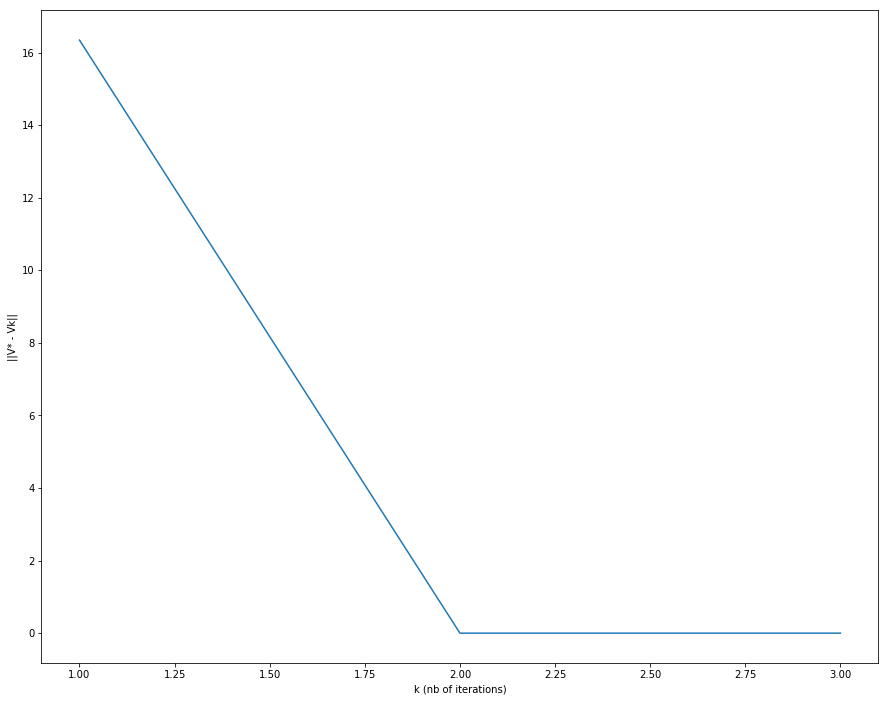

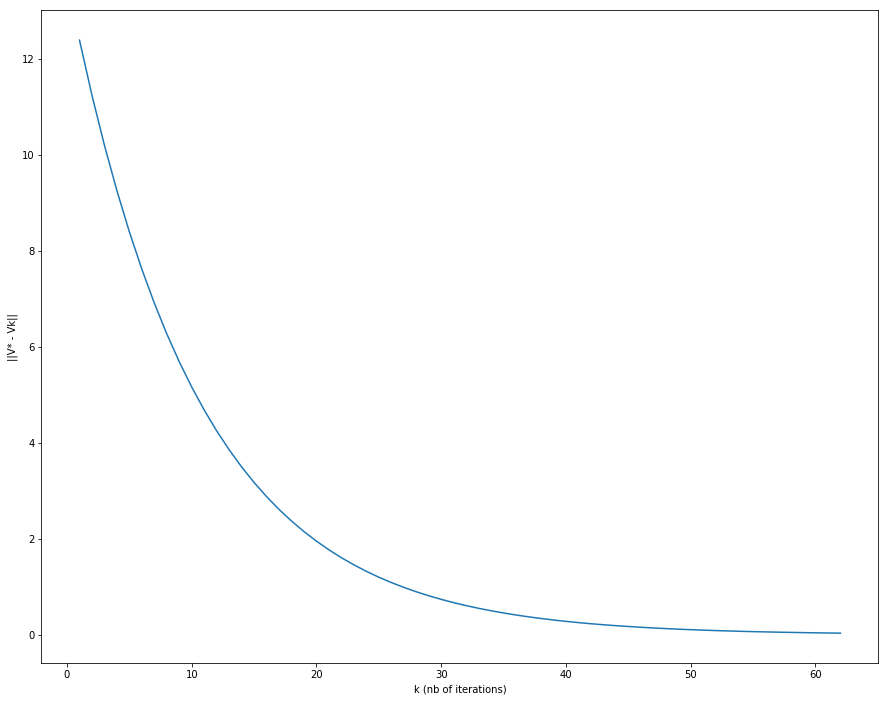

In [4]:
pol = RL()
pol.set_vstar(pol.policy_evaluation([1, 0, 1]))

# policy iteration
pol.policy_iteration(0.01)
pol.plot()

# value iteration
pol.value_iteration(0.01)
pol.plot()

In [5]:
from gridworld import GridWorld1
import gridrender

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

S, A_s, P, R, gamma, pi = GridWorld1.matrix_representation()

In [6]:
v_q4 = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514]

q_q4 = [[0.87691855, 0.65706417],
        [0.92820033, 0.84364237],
        [0.98817903, -0.75639924, 0.89361129],
        [0.00000000],
        [-0.62503460, 0.67106071],
        [-0.99447514, -0.70433689, 0.75620264],
        [0.00000000],
        [-0.82847001, 0.49505225],
        [-0.87691855, -0.79703229],
        [-0.93358351, -0.84424050, -0.93896668],
        [-0.89268904, -0.99447514]
        ]

v_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001]

In [10]:
GridWorld1.render = False

class RL2:
    def __init__(self, env):
        self.env = env
        self.S, self.A_s, self.P, self.R, self.gamma, self.mu0 = env.matrix_representation()
        self.A = self.P.shape[1]
        self.Vpi = None
        self.Jpi = None
        self.Vstar = None
        
        self.epoch = []
        self.values = []
    
    def nextAction(self, s):
        """Returns right action if available, otherwise go right"""
        return 0 if 0 in self.env.state_actions[s] else 3

    def setVpi(self, v):
        self.Vpi = np.array(v)
        self.Jpi = self.Vpi.dot(self.mu0)
        
    def setVstar(self, v):
        self.Vstar = np.array(v)
    
    def addPoint(self, Q, N, e):
        # don't forget to normalize beforehand
        N_temp = N.copy()
        Q_temp = Q.copy()
        
        N_temp[N == 0] += 1
        Q_temp /= N_temp
        
        V = np.zeros(self.S)
        for s in range(self.S):
            V[s] = Q_temp[s, self.nextAction(s)]
        
        self.epoch.append(e)
        self.values.append(self.mu0.dot(V) - self.Jpi)
    
    def MC1(self, E, T):
        
        Q = np.zeros((self.S,self.A+1))
        N = np.zeros((self.S,self.A+1))

        for e in range(E):
            s = self.env.reset()
            a = self.nextAction(s)

            N[s,a] += 1

            # temp variables
            s0 = s
            a0 = a

            t = 0
            term = False
            while t < T or not term:
                s, r, term = self.env.step(s, a)
                Q[s0, a0] +=  gamma**t * r

                a = self.nextAction(s)
                t += 1
            
            # compute J and add it to self.values
            if self.Vpi is not None:
                self.addPoint(Q, N, e)
            
        N[N == 0] += 1
        Q /= N

        return Q
    
    def MC2(self, E, T):
        Q = np.zeros((self.S,self.A+1))
        
        for s in range(S):
            for e in range(E):
                s_temp = s

                t = 0
                term = False
                while t < T or not term:
                    a = self.nextAction(s_temp)
                    s_temp, r, term = self.env.step(s_temp, a)
                    Q[s,a] +=  gamma**t * r
                    t += 1
            
        Q = Q / E

        return Q
    
    def MC(self, E, T, n=1):
        """
            If n == 1 return the Q value using first visit MC method
            otherwise return the Q value using multi visit MC method
        """
        return self.MC1(E, T) if n == 1 else self.MC2(E, T)
    
    def epsGreedy(self, Q, s, eps):
        r = np.random.uniform(0,1,1)
        x = sum( r > np.cumsum([0, 1-eps, eps]))
        
        if x == 1: # exploit (act greedily)
            return np.argmax(Q[s, :])
        else: # explore
            return np.random.choice(self.env.state_actions[s])
        
    def qlearning(self, E, T, eps):
        Q = np.zeros((self.S, self.A + 1))
        N = np.zeros((self.S, self.A + 1))
        
        possible_action = np.zeros((self.S, self.A + 1), dtype=bool)
        for i, s in enumerate(self.A_s):
            possible_action[i, s] = True
        Q[~possible_action] = -inf
        
        # to measure the cumulated reward over the episode
        R = 0
        for e in range(E):
            s = self.env.reset()
            
            term = False
            t = 0
            R_tmp = 0
            while t < T and not term:
                
                a = self.epsGreedy(Q, s, eps)
                
                # update alpha
                N[s, a] += 1
                alpha = 1 / N[s, a]
                
                next_s, r, term = self.env.step(s, a)
                Q[s,a] = Q[s,a]*(1-alpha) + alpha*(r + self.gamma * np.max(Q[next_s, :]))
                
                s = next_s                
                t += 1
                R_tmp += self.gamma**(t-1) * r
            
            if self.Vstar is not None:
                self.epoch.append(e)
                
                # (1)
                # Uncomment below to see V* - Vn (and comment cumulated reward)
                # difference w.r.t the optimal policy
                self.values.append(np.linalg.norm(np.max(Q, axis=1) - self.Vstar, inf))
                
                # (2)
                # reward cumulated over the episode
                #R += R_tmp
                #self.values.append(R)
        
        return np.max(Q, axis=1)
    
    def plot(self):
        if self.Vpi is not None or self.Vstar is not None:
            plt.figure(figsize=(12,10))
            plt.plot(self.epoch, self.values)
            plt.xlabel("n (nb of iterations)")
            #plt.ylabel("Reward")
            #plt.ylabel("Jn - Jpi")
            plt.ylabel("||v* - vpin||")

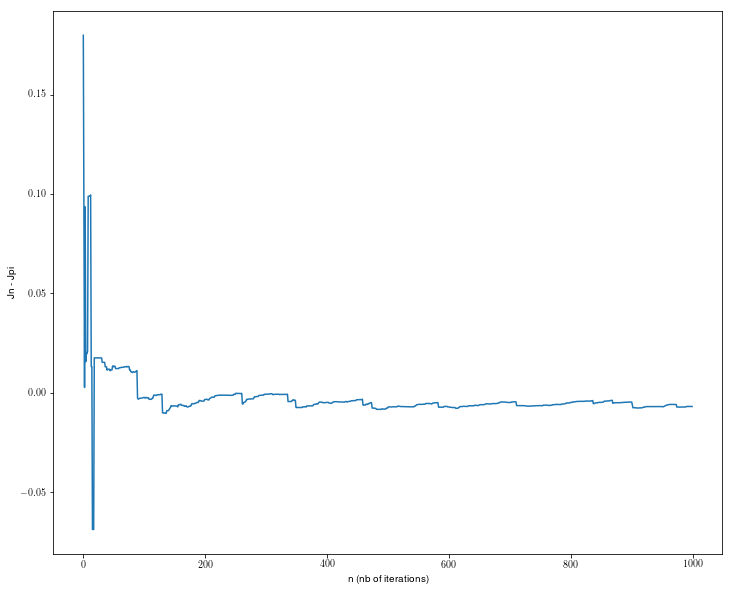

In [20]:
rl2 = RL2(GridWorld1)
rl2.setVpi(v_q4)
rl2.MC(1000, 100)
rl2.plot()

__Note__: to plot Q-learning curve you need to comment line under (2) and uncomment line under (1)

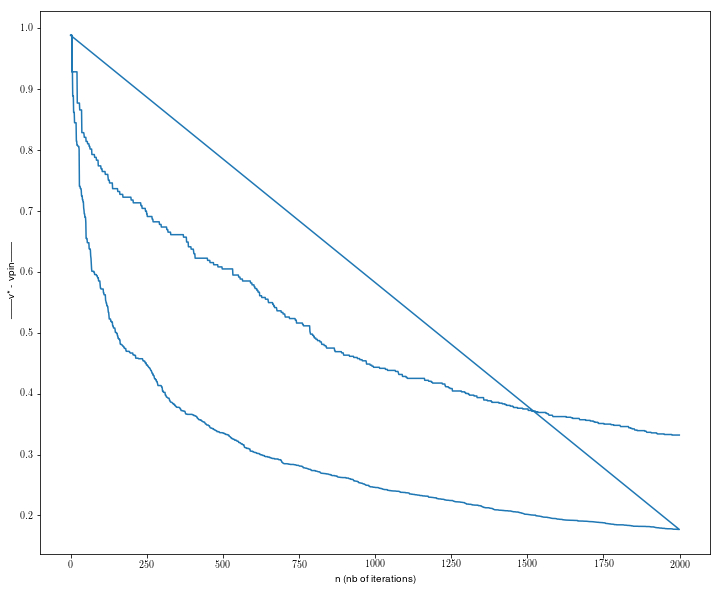

In [20]:
rl2 = RL2(GridWorld1)
rl2.setVstar(v_opt)
rl2.qlearning(2000, 100, 1)
rl2.qlearning(2000, 100, 0.25)
rl2.plot()